In [1]:
import io
import os
import re
import shutil
import string
import pickle

from keras.backend import int_shape
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import load_model
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.losses import BinaryCrossentropy
import tensorflow_addons as tfa
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow_addons.metrics import HammingLoss

In [2]:
# !pip install tensorflow_addons  # Run in colab

In [3]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
print("TF version", tf.version.VERSION)
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

TF version 2.4.1
GPU device not found


In [4]:
DATA_PATH = "./data/"
MODEL_PATH_SMALL = "./models_small/"
MODEL_PATH_BIG = "./models_big/"

In [5]:
clean_recipes = pd.read_csv(DATA_PATH + 'clean_recipes.csv', delimiter=';')
clean_recipes = clean_recipes.dropna(subset=["Directions"])

In [6]:
clean_recipes

,Recipe Name,Review Count,Recipe Photo,Author,Prepare Time,Cook Time,Total Time,Ingredients,Directions,RecipeID
0,Golden Crescent Rolls Recipe,304,https://images.media-allrecipes.com/userphotos...,Mike A.,25 m,15 m,3 h 10 m,"yeast,water,white sugar,salt,egg,butter,flour,...","Dissolve yeast in warm water.**Stir in sugar, ...",7000
1,Poppy Seed Bread with Glaze Recipe,137,https://images.media-allrecipes.com/userphotos...,Christina Jun,15 m,1 h,1 h 20 m,"flour,salt,baking powder,poppy,butter,vegetabl...",'Preheat oven to 350 degrees F (175 degrees C)...,7001
2,Applesauce Bread I Recipe,124,https://images.media-allrecipes.com/userphotos...,GAF55,10 m,1 h 20 m,1 h 30 m,"flour,egg,white sugar,vegetable oil,applesauce...",Preheat oven to 350 degrees F (175 degrees C)....,7003
3,Apple Raisin Bread Recipe,39,https://images.media-allrecipes.com/userphotos...,Helen Hanson,15 m,1 h,1 h 15 m,"flour,baking powder,baking soda,salt,cinnamon,...",Preheat oven to 350 degrees F (175 degrees C)....,7006
4,Buttermilk Oatmeal Bread Recipe,41,https://images.media-allrecipes.com/userphotos...,Helen Hanson,10 m,1 h,1 h 40 m,"oat,buttermilk,vegetable oil,egg,brown sugar,f...",Mix oats with buttermilk. Let stand for 1/2 h...,7007
...,...,...,...,...,...,...,...,...,...,...
12346,Hot Coffee Frosting Recipe,5,https://images.media-allrecipes.com/userphotos...,Jean,30 m,30 m,1 h,"sugar,butter,cocoa powder,vanilla,coffee","'In a large bowl, combine confectioners'' suga...",27456
12347,White Chocolate Blueberry Cheesecake Recipe,78,https://images.media-allrecipes.com/userphotos...,Scott M.,20 m,1 h,1 h 20 m,"CRUST:,ham,almond,white sugar,butter,caramel,F...",Preheat oven to 275 degrees F (135 degrees C)....,27478
12348,'Aunt Anne''s Coffee Cake Recipe ',704,https://images.media-allrecipes.com/userphotos...,Mary,20 m,25 m,45 m,"flour,white sugar,baking powder,salt,butter,eg...",Preheat oven to 350 degrees F (175 degrees C)....,27491
12349,Giant Ding Dong Cake Recipe,157,https://images.media-allrecipes.com/userphotos...,TheThreeDogKitchen,25 m,50 m,2 h 15 m,"cake,chocolate,egg,water,vegetable oil,flour,m...",Preheat oven to 350 degrees F (175 degrees C)....,27511


In [7]:
ingredients = clean_recipes.Ingredients
ingredients.head()

0    yeast,water,white sugar,salt,egg,butter,flour,...
1    flour,salt,baking powder,poppy,butter,vegetabl...
2    flour,egg,white sugar,vegetable oil,applesauce...
3    flour,baking powder,baking soda,salt,cinnamon,...
4    oat,buttermilk,vegetable oil,egg,brown sugar,f...
Name: Ingredients, dtype: object

In [8]:
directions = clean_recipes.Directions
directions

0        Dissolve yeast in warm water.**Stir in sugar, ...
1        'Preheat oven to 350 degrees F (175 degrees C)...
2        Preheat oven to 350 degrees F (175 degrees C)....
3        Preheat oven to 350 degrees F (175 degrees C)....
4        Mix oats with buttermilk.  Let stand for 1/2 h...
                               ...                        
12346    'In a large bowl, combine confectioners'' suga...
12347    Preheat oven to 275 degrees F (135 degrees C)....
12348    Preheat oven to 350 degrees F (175 degrees C)....
12349    Preheat oven to 350 degrees F (175 degrees C)....
12350    Preheat oven to 350 degrees F (175 degrees C)....
Name: Directions, Length: 12345, dtype: object

In [9]:
directions[3889]

"'Sift together the flour, sugar, and salt into a bowl.**Toss butter through flour mixture to coat pieces. Using fingertips, rub fat into flour, working it until you have created a coarse meal with a few pea-size particles of fat.**Empty crumbs onto a cool surface.  Form mixture into a mound.  Make a 4 to 5 inch well in center of the mound.  Combine egg and vanilla and pour mixture into the well.  Using a fork, draw crumbs into egg mixture, about 1 - 2 tablespoons at a time.  When all crumbs are added, toss mixture a few times with a pastry blender to form large clumps, then scrape into a mound.**Using the heel of your hand, push 2 - 3 tablespoons of the dough at a time, outward in 6 to 8 inch sweeps.  This will blend fat and flour and give crust a delicate texture.  If your hand becomes sticky, flour it as needed.  Repeat process until all dough has been worked.  Gather dough into a mound again.  Repeat procedure 2 more times.**After third time, flour your hands.  Gently knead the dou

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

_t = np.array(clean_recipes["Ingredients"])
cv = CountVectorizer()
cv.fit(_t)
for i, (k,v) in enumerate({k: v for k, v in sorted(cv.vocabulary_.items(), key=lambda item: item[1])}.items()):
    print(k,v)
    if i==5:
        break
for i, (k,v) in enumerate({k: v for k, v in sorted(cv.vocabulary_.items(), key=lambda item: item[1], reverse=True)}.items()):
    print(k,v)
    if i==5:
        break
cv.vocabulary_["sugar"]
_t

10 0
100 1
12 2
14 3
15 4
16 5
zwieback 797
zucchini 796
zinfandel 795
zest 794
yum 793
yogurt 792


array(['yeast,water,white sugar,salt,egg,butter,flour,butter',
       'flour,salt,baking powder,poppy,butter,vegetable oil,egg,milk,white sugar,vanilla,almond,orange juice,butter,almond,vanilla,sugar',
       'flour,egg,white sugar,vegetable oil,applesauce,raisin,cinnamon,baking soda,baking powder,sour cream',
       ...,
       'flour,white sugar,baking powder,salt,butter,egg,milk,vanilla,flour,white sugar,cinnamon,butter',
       'cake,chocolate,egg,water,vegetable oil,flour,milk,shortening,butter,white sugar,vanilla,chocolate,shortening,corn syrup,water',
       'peach,brown sugar,cornstarch,vegetable oil,flour,white sugar,baking powder,lemon,egg,vanilla,vegetable oil,orange juice'],
      dtype=object)

In [11]:
nltk.download('wordnet')
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_pipeline(text, delimiter=" "):
#     text = text.lower()
    import re
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    tokens = []
    for token in text.split(delimiter):
#         token = lemmatizer.lemmatize(token)
        token = ps.stem(token)
        if token:
            tokens.append(token)
    text = delimiter.join(tokens)
    return text


def save_obj(obj, path):
  _file = open(path, "wb")
  pickle.dump(obj, _file)
  _file.close()

def load_obj(path):
  _file = open(path,'rb')
  obj = pickle.load(_file)
  _file.close()
  return obj

def evaluate(model, train_ds, test_ds,  X_train, y_train,  X_test, y_test, train_batch, test_batch):
    y_score = model.predict(train_ds.batch(X_train.shape[0]))
    y_pred = (y_score > 0.5) .astype(int)

    y_score_test = model.predict(test_ds.batch(X_test.shape[0]))
    y_pred_test = (y_score_test > 0.5).astype(int)

    print("train")
    result = model.evaluate(train_ds.batch(X_train.shape[0]))
  
    print("test")
    result = model.evaluate(test_ds.batch(X_test.shape[0]))


[nltk_data] Downloading package wordnet to /home/sergiuz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
# text = "I love Machine8 learning** and Footb*all"
# preprocess_pipeline(text)
directions = directions.apply(preprocess_pipeline)
print(directions)
mlb = MultiLabelBinarizer()
label = mlb.fit_transform(ingredients.str.split(',').values)

0        dissolv yeast in warm waterstir in sugar salt ...
1        preheat oven to 350 degre f 175 degre c greas ...
2        preheat oven to 350 degre f 175 degre c greas ...
3        preheat oven to 350 degre f 175 degre c greas ...
4        mix oat with buttermilk let stand for 12 hours...
                               ...                        
12346    in a larg bowl combin confection sugar butter ...
12347    preheat oven to 275 degre f 135 degre c make t...
12348    preheat oven to 350 degre f 175 degre c greas ...
12349    preheat oven to 350 degre f 175 degre c greas ...
12350    preheat oven to 350 degre f 175 degre c lightl...
Name: Directions, Length: 12345, dtype: object


In [13]:
# directions10, _, _, _ =  train_test_split(directions, label, train_size=0.2, random_state=42)  # Use only 20% of data
# ingredients10 = ingredients.loc[directions10.index]
# mlb = MultiLabelBinarizer()
# label10 = mlb.fit_transform(ingredients10.str.split(',').values)
# noutputs = label10.shape[1]
# X_train, X_test, y_train, y_test =  train_test_split(directions10, label10, test_size=0.25, random_state=42)

mlb = MultiLabelBinarizer()
label = mlb.fit_transform(ingredients.str.split(',').values)
noutputs = label.shape[1]
X_train, X_test, y_train, y_test =  train_test_split(directions, label, test_size=0.25)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [14]:
noutputs, mlb.classes_.shape, label.shape

(943, (943,), (12345, 943))

In [15]:
vocab_size = 10000
sequence_length = 200
EMBEDDINGS_DIM = 200

vectorization1 = TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

vectorization2 = TextVectorization(
    max_tokens=vocab_size,
    output_mode='binary',
    ngrams=(1, 2),
    )

vectorization3 = TextVectorization(
    max_tokens=vocab_size,
    output_mode="tf-idf",
    ngrams=(1, 2),
    )

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_ds = train_ds.map(lambda x, y: x)
vectorization1.adapt(text_ds)
vectorization2.adapt(text_ds)
vectorization3.adapt(text_ds)

# metrics=['accuracy', HammingLoss(name="hamming_loss", mode='multilabel'), Precision(name='precision'), Recall(name='recall')]
metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
metrics_name = [m if isinstance(m, str) else m.name  for m in metrics]


def plot_graphs(history, metrics=["loss"] + metrics_name):
  plt.figure(figsize=(80, 15))

  for i, metric in enumerate(metrics):
    plt.subplot(1, len(metrics_name)+1, i+1)
    plt.plot(history[metric])
    plt.plot(history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

train
1/1 [==============================] - 3s 3s/step - loss: 0.0252 - accuracy: 0.0177 - precision: 0.7027 - recall: 0.1836
test
1/1 [==============================] - 1s 520ms/step - loss: 0.0253 - accuracy: 0.0117 - precision: 0.7116 - recall: 0.1867


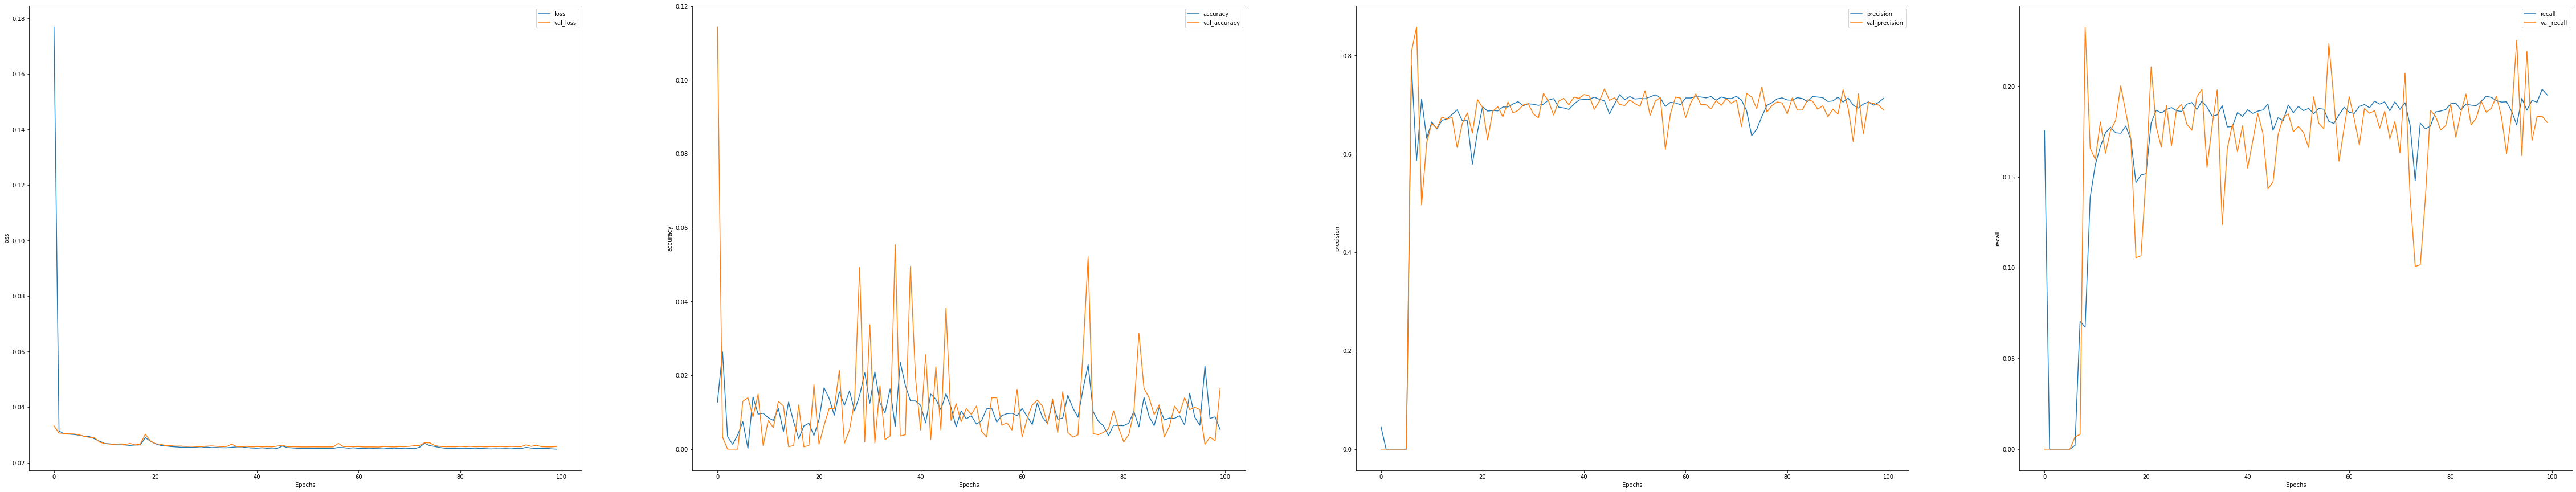

In [16]:
BATCH_SIZE = 1024
BATCH_SIZE_TEST = X_test.shape[0]
SHUFFLE = 10000
EPOCHS = 100
LEARNING_RATE = 1e-1
VERSION = 1
MODEL_NAME = "model1"
MODEL_PATH = MODEL_PATH_BIG + MODEL_NAME + "/" + str(VERSION) + "/"

# model = Sequential([
#     vectorization1,
#     layers.Embedding(vocab_size, embedding_dim, name="embedding"),
#     layers.GlobalAveragePooling1D(),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(32, activation='relu'),
#     layers.Dense(noutputs, activation='sigmoid')])

# model.compile(loss=BinaryCrossentropy(from_logits=False, label_smoothing=0, name='binary_crossentropy'),
#               optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
#               metrics=metrics)

# model_history = model.fit(train_ds.batch(BATCH_SIZE).shuffle(SHUFFLE), validation_data=test_ds.batch(BATCH_SIZE_TEST), epochs=EPOCHS)
# model.save(MODEL_PATH)
# save_obj(model_history.history, MODEL_PATH + MODEL_NAME + "_history.pkl")
# save_obj(mlb, MODEL_PATH + MODEL_NAME + "_mbl.pkl")

model = load_model(MODEL_PATH)
evaluate(model, train_ds, test_ds,  X_train, y_train,  X_test, y_test, X_train.shape[0], X_test.shape[0])
plot_graphs(load_obj(MODEL_PATH + MODEL_NAME + "_history.pkl"))